In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import datetime
import seaborn as sns
from pandas import Timestamp

In [123]:
file_directory =  '/Users/sainikhil/Downloads/RADISH/2023-04-19 Cypress 101 data/MVDS raw data'
df = pd.read_csv(file_directory+'/Lane_Readings_15446-1-45827.csv')
df['measurement_start_timestamp'] = df['measurement_start'].apply(lambda x:str(x.split('T')[0]) + str(' ')+str(x.split('T')[1].split('-')[0]))
df = df.dropna(subset=['speed', 'volume', 'occupancy'])
df = df[(df['speed']>=0) & (df['volume']>=0) & (df['occupancy']>=0)]
df['measurement_start_timestamp'] = pd.to_datetime(df['measurement_start_timestamp'])


In [124]:
df

,zone_id,lane_number,lane_id,measurement_start,speed,volume,occupancy,quality,measurement_start_timestamp
0,15446,1,45827,2023-04-19T00:00:01-04:00,64.0,2,6,0,2023-04-19 00:00:01
1,15446,1,45827,2023-04-19T00:00:21-04:00,62.0,1,1,0,2023-04-19 00:00:21
3,15446,1,45827,2023-04-19T00:01:01-04:00,65.0,1,4,0,2023-04-19 00:01:01
4,15446,1,45827,2023-04-19T00:01:21-04:00,65.0,1,1,0,2023-04-19 00:01:21
5,15446,1,45827,2023-04-19T00:01:41-04:00,56.0,3,4,0,2023-04-19 00:01:41
...,...,...,...,...,...,...,...,...,...
4310,15446,1,45827,2023-04-19T23:57:33-04:00,73.0,1,1,0,2023-04-19 23:57:33
4311,15446,1,45827,2023-04-19T23:57:53-04:00,70.0,4,4,0,2023-04-19 23:57:53
4312,15446,1,45827,2023-04-19T23:58:13-04:00,65.0,1,1,0,2023-04-19 23:58:13
4313,15446,1,45827,2023-04-19T23:58:33-04:00,71.0,3,3,0,2023-04-19 23:58:33


In [173]:
def plot_congestion(df,t,lane_number):
    df_average_speed = pd.DataFrame({'Average Speed':df.groupby(pd.Grouper(key='measurement_start_timestamp',freq='{}min'.format(t))).speed.mean()}).reset_index()

    df_max_speed = pd.DataFrame({'Max Speed':df.groupby(pd.Grouper(key='measurement_start_timestamp',freq='{}min'.format(t))).speed.max()}).reset_index()


    df_average_flow = pd.DataFrame({'Average Flow':df.groupby(pd.Grouper(key='measurement_start_timestamp',freq='{}min'.format(t))).volume.sum()}).reset_index()


    df_average_occupancy = pd.DataFrame({'Average Occupancy':df.groupby(pd.Grouper(key='measurement_start_timestamp',freq='{}min'.format(t))).occupancy.mean()}).reset_index()
    df_aggregate = pd.merge(df_average_speed, df_average_flow, on='measurement_start_timestamp',how='left')
    df_aggregate = pd.merge(df_aggregate, df_average_occupancy, on='measurement_start_timestamp',how='left')
    df_aggregate = pd.merge(df_aggregate, df_max_speed, on='measurement_start_timestamp',how='left')

    df_aggregate['Average Flow Rate'] = df_aggregate['Average Flow'].apply(lambda x:(x*60)/t)
    df_aggregate['Congestion measure'] = df_aggregate['Average Speed']/df_aggregate['Max Speed']
    df_aggregate = df_aggregate[(df_aggregate['measurement_start_timestamp']>=Timestamp('2023-04-19 15:15:00'))&(df_aggregate['measurement_start_timestamp']<=Timestamp('2023-04-19 18:00:00'))].reset_index(drop=True)

    timestamps = []
    for i in range(len(df_aggregate)-1):
        if i%12 == 0:
            timestamps.append(df_aggregate['measurement_start_timestamp'][i])
    #timestamps
    
    quartiles = np.percentile(df_aggregate['Congestion measure'], [33, 67])
    colors = ['red', 'blue', 'green']  
    plt.figure(figsize=(8, 5)) 
    df_sorted = df_aggregate.sort_values('measurement_start_timestamp')
    x = df_sorted['measurement_start_timestamp']
    y = df_sorted['Congestion measure']
    scatter_colors_array = np.empty(len(y), dtype=str)
    scatter_colors_array[y < quartiles[0]] = colors[0]
    scatter_colors_array[(y >= quartiles[0]) & (y <= quartiles[1])] = colors[1]
    scatter_colors_array[y > quartiles[1]] = colors[2]
    plt.scatter(x, y, color=scatter_colors_array, s=10)
    line_colors_array = np.empty(len(y) - 1, dtype=str)

    print(df_aggregate)

    for i in range(len(y) - 1):
        if y[i] < quartiles[0]:
            line_colors_array[i] = colors[0]
        elif y[i] <= quartiles[1]:
            line_colors_array[i] = colors[1]
        else:
            line_colors_array[i] = colors[2]
        plt.step([x[i], x[i + 1]], [y[i], y[i + 1]], color=line_colors_array[i],where='post')


    plt.title('Congestion Measure Over Time, Aggregated over 5 minutes interval, General Purpose Lane {}'.format(lane_number))
    plt.xlabel('Measurement Start Timestamp')
    plt.xticks(ticks=df_aggregate['measurement_start_timestamp'], labels=df_aggregate['measurement_start_timestamp'], rotation=45)
    plt.ylabel('Congestion measure')

    legend_handles = [Line2D([0], [0], color='red', lw=2),Line2D([0], [0], color='green', lw=2),Line2D([0], [0], color='blue', lw=2)]
    legend_labels = ['High Congestion', 'Low Congestion', 'Moderate Congestion']
    plt.legend(legend_handles, legend_labels)
    plt.grid(True)
    plt.show()
    print(quartiles)

   measurement_start_timestamp  Average Speed  Average Flow  \
0          2023-04-19 15:15:00      27.133333            96   
1          2023-04-19 15:20:00      13.800000            62   
2          2023-04-19 15:25:00      12.600000            56   
3          2023-04-19 15:30:00      23.466667           105   
4          2023-04-19 15:35:00      20.800000            93   
5          2023-04-19 15:40:00      20.866667            87   
6          2023-04-19 15:45:00      17.200000            79   
7          2023-04-19 15:50:00      15.400000            74   
8          2023-04-19 15:55:00      16.400000            84   
9          2023-04-19 16:00:00      18.333333            83   
10         2023-04-19 16:05:00      17.800000            86   
11         2023-04-19 16:10:00      20.533333            90   
12         2023-04-19 16:15:00      18.266667            72   
13         2023-04-19 16:20:00      18.866667            93   
14         2023-04-19 16:25:00      19.266667          

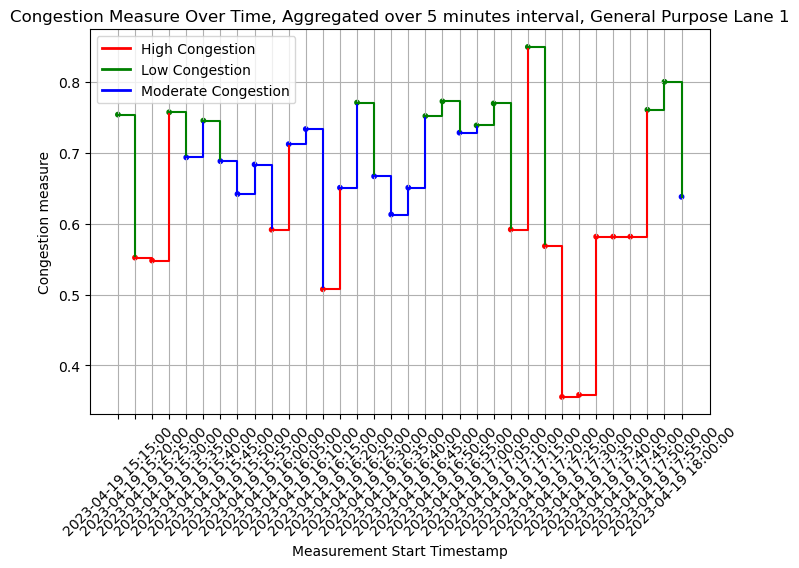

[0.61049359 0.73389744]


In [174]:
plot_congestion(df,5,1)

In [10]:
#Average Speed is in mph
#Average Occupancy is in %
#Average Flow Rate is in Veh per hour

#Small numbers indicat
fig = plt.figure(figsize=(8,5)) 
ax = fig.add_subplot(111)


ax.set_xlabel('Intervals of 5 minutes')
ax.set_ylabel('Congestion measure')
#plt.xticks(rotation=45)
#plt.legend(['upstream','near-merge','downstream'])
percentiles = df_aggregate['Congestion measure'].quantile([0.33, 0.67, 1])
percentiles = np.array(percentiles)
#percentiles
#colors = np.where(df_aggregate['Congestion measure'] > percentiles[1], 'red', np.where(df_aggregate['Congestion measure'] < percentiles[0], 'orange', 'green'))

# legend_handles = [
#     Line2D([0], [0], color='red', lw=2),
#     Line2D([0], [0], color='orange', lw=2),
#     Line2D([0], [0], color='green', lw=2)
# ]
# legend_labels = ['Above Threshold', 'Below Threshold', 'Within Threshold']
ax.plot(df_aggregate[df_aggregate['Congestion measure']>0.85]['measurement_start_timestamp'],df_aggregate[df_aggregate['Congestion measure']>0.85]['Congestion measure'],color='red')
ax.plot(df_aggregate[df_aggregate['Congestion measure']>0.79]['measurement_start_timestamp'],df_aggregate[df_aggregate['Congestion measure']>0.79]['Congestion measure'],color='orange')
ax.plot(df_aggregate[df_aggregate['Congestion measure']<=0.79]['measurement_start_timestamp'],df_aggregate[df_aggregate['Congestion measure']<=0.79]['Congestion measure'],color='green')

#plt.plot(df_aggregate['measurement_start_timestamp'],df_aggregate[df_aggregate['Congestion measure']>0.79],color='orange')
#plt.plot(df_aggregate['measurement_start_timestamp'],df_aggregate[df_aggregate['Congestion measure']<=0.79],color='green')

# Add legend
#plt.legend(legend_handles, legend_labels)
#Range is 0.35 to 0.95

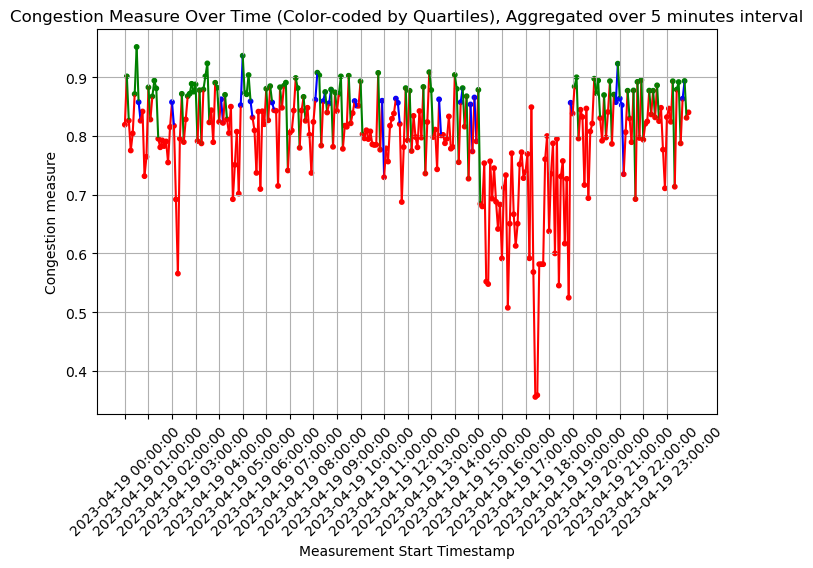

[0.85151926 0.86588542]


In [88]:

timestamps = []
for i in range(len(df_aggregate)-1):
    if i%12 == 0:
        timestamps.append(df_aggregate['measurement_start_timestamp'][i])
timestamps
import numpy as np
import matplotlib.pyplot as plt
quartiles = np.percentile(df_aggregate['Congestion measure'], [67, 75])
colors = ['red', 'blue', 'green']  
plt.figure(figsize=(8, 5)) 
df_sorted = df_aggregate.sort_values('measurement_start_timestamp')
x = df_sorted['measurement_start_timestamp']
y = df_sorted['Congestion measure']
scatter_colors_array = np.empty(len(y), dtype=str)
scatter_colors_array[y < quartiles[0]] = colors[0]
scatter_colors_array[(y >= quartiles[0]) & (y <= quartiles[1])] = colors[1]
scatter_colors_array[y > quartiles[1]] = colors[2]
plt.scatter(x, y, color=scatter_colors_array, s=10)
line_colors_array = np.empty(len(y) - 1, dtype=str)

 

for i in range(len(y) - 1):
    if y[i] < quartiles[0]:
        line_colors_array[i] = colors[0]
    elif y[i] <= quartiles[1]:
        line_colors_array[i] = colors[1]
    else:
        line_colors_array[i] = colors[2]
    plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], color=line_colors_array[i])


plt.title('Congestion Measure Over Time (Color-coded by Quartiles), Aggregated over 5 minutes interval')
plt.xlabel('Measurement Start Timestamp')

plt.ylabel('Congestion measure')

plt.xticks(ticks=timestamps, labels=timestamps, rotation=45)

plt.grid(True)
plt.show()
print(quartiles)

In [ ]:
#Average Occupancy can be less even when Average speed is less

# Information from Event Detail sheet

In [118]:
file_name = '/Users/sainikhil/Downloads/RADISH/2023-04-19 Cypress 101 data/101_Cypress_EventReport_1858.csv'




def plot_function(df_main,t):
    df_event_detail = df_main.copy(deep=True)
    df_gr = pd.DataFrame({'Aggregate ramp metering rate':df_event_detail.query('Type == "Ramp Meter - Lane 1 Active Rate"').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.mean()}).reset_index()
    df_gr2 = pd.DataFrame({'Aggregate Mainline num vehicles':df_event_detail.query('Type == "Detector On" & Event_value==11').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.count()}).reset_index()
    df_gr2['Aggregate Mainline flow rate'] = df_gr2['Aggregate Mainline num vehicles'].apply(lambda x: x*(60/t))
    df_gr4 = pd.DataFrame({'Aggregate Ramp Demand num vehicles':df_event_detail.query('Type == "Detector On" & Event_value==21').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.count()}).reset_index()
    df_gr4['Aggregate Ramp Demand flow rate'] = df_gr4['Aggregate Ramp Demand num vehicles'].apply(lambda x: x*(60/t))
    df_gr5 = pd.DataFrame({'Aggregate Ramp Passage num vehicles':df_event_detail.query('Type == "Detector On" & Event_value==23').groupby([pd.Grouper(key='Timestamp',freq='{}min'.format(t)),'Type']).Event_value.count()}).reset_index()
    df_gr5['Aggregate Ramp Passage flow rate'] = df_gr5['Aggregate Ramp Passage num vehicles'].apply(lambda x: x*(60/t))

    df_green_time_estimation = df_event_detail.loc[(df_event_detail['Type']=='Ramp Meter - Begin Green') | (df_event_detail['Type']=='Ramp Meter - Begin Red')].reset_index(drop=True)


    


    green_time_array = []
    all_start_timestamps = np.array(df_gr2['Timestamp'])
    for i in range(len(df_gr2)):
        s = df_gr2['Timestamp'][i]
        e = df_gr2['Timestamp'][i] + datetime.timedelta(minutes=t)
        df = df_green_time_estimation.loc[(df_green_time_estimation['Timestamp']>= df_gr2['Timestamp'][i])& (df_green_time_estimation['Timestamp']< df_gr2['Timestamp'][i]+datetime.timedelta(minutes=t))].reset_index(drop=True)
        if len(df)==0:
            green_time_array.append(0)
        else:
            green_time_array.append(green_time_calculator(df,s,e))
            
    df_gr3 = pd.DataFrame()
    df_gr3['Timestamp'] = all_start_timestamps
    df_gr3['Green_time'] = green_time_array

    print('*************************************{} Minute Aggregate******************************'.format(t))
    #print(df_gr2)
    fig, ax = plt.subplots(5,1)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax[0].step(df_gr2['Timestamp'],df_gr2['Aggregate Mainline flow rate'],color='blue',where='post')
    ax[0].set_xlabel('Timestamp')
    ax[0].set_ylabel('Mainline flow rate')
    #ax[0].legend(['Mainline flow rate from Detector 11'])
    ax[0].set_xticks(df_gr2['Timestamp'],df_gr2['Timestamp'],rotation=45)
    ax[0].text(0.1, 0.1, 'Detector 11', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    ax[0].text(0.1, 0.2, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    #ax2.text(0.9, 0.5, 'End text', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    

    ax[1].step(df_gr4['Timestamp'],df_gr4['Aggregate Ramp Demand flow rate'],color='orange',where='post')
    ax[1].set_xlabel('Timestamp')
    ax[1].set_ylabel('Ramp Demand flow rate')
    ax[1].set_ylim(0,800)
    #ax[1].legend(['Ramp Demand flow rate from Detector 21'])
    ax[1].set_xticks(df_gr4['Timestamp'],df_gr4['Timestamp'],rotation=45)
    ax[1].text(0.1, 0.1, 'Detector 21', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
    ax[1].text(0.1, 0.2, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)



    ax[2].step(df_gr5['Timestamp'],df_gr5['Aggregate Ramp Passage flow rate'],color='red',where='post')
    ax[2].set_xlabel('Timestamp')
    ax[2].set_ylabel('Ramp Passage flow rate')
    ax[2].set_ylim(0,800)
    #ax[2].legend(['Ramp Passage flow rate from Detector 23'])
    ax[2].set_xticks(df_gr4['Timestamp'],df_gr4['Timestamp'],rotation=45)
    ax[2].text(0.1, 0.1, 'Detector 23', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
    ax[2].text(0.1, 0.2, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)


    ax[3].step(df_gr['Timestamp'],df_gr['Aggregate ramp metering rate'],color='black',where='post')
    ax[3].set_xlabel('Timestamp')
    ax[3].set_ylabel('Ramp metering rate')
    ax[3].set_xticks(df_gr['Timestamp'],df_gr['Timestamp'],rotation=45)
    ax[3].text(0.1, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes)
    

    ax[4].step(df_gr3['Timestamp'],df_gr3['Green_time'],color='green',where='post')
    ax[4].set_xlabel('Timestamp')
    ax[4].set_ylabel('Green time')
    ax[4].set_xticks(df_gr3['Timestamp'],df_gr3['Timestamp'],rotation=45)
    ax[4].text(0.1, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax[4].transAxes)
    



    fig.subplots_adjust(hspace=1.5)
    plt.show()
    
    #Make scatter plots between mainline flow rate vs Ramp metering rate
    #Demand vs Passage ramp
    #Ramp metering rate vs Green time
    #Make scatter plots between 11 and 23

    df_flow_rate_ramp_rate = df_gr2.merge(df_gr,on='Timestamp',how='right')
    df_passage_demand = df_gr4.merge(df_gr5,on='Timestamp',how='right')
    df_green_ramp_rate = df_gr3.merge(df_gr,on='Timestamp',how='right')
    df_passage_mainline = df_gr2.merge(df_gr5,on='Timestamp',how='right')

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    #plt.text(0.5,0.3,'hi')
    ax.scatter(df_flow_rate_ramp_rate['Aggregate ramp metering rate'],df_flow_rate_ramp_rate['Aggregate Mainline flow rate'])
    ax.set_ylabel('Aggregate Mainline flow rate from Detector 11')
    ax.set_xlabel('Aggregate Ramp Metering rate')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Ramp Metering rate vs Mainline flow rate')
    plt.show()

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    ax.scatter(df_passage_demand['Aggregate Ramp Demand flow rate'],df_passage_demand['Aggregate Ramp Passage flow rate'],c='r')
    ax.set_ylabel('Aggregate Ramp Passage flow rate from Detector 23')
    ax.set_xlabel('Aggregate Ramp Demand flow rate from Detector 21')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Ramp Passage vs Ramp Demand')
    plt.show()

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    ax.scatter(df_green_ramp_rate['Aggregate ramp metering rate'],df_green_ramp_rate['Green_time'],c='g')
    ax.set_ylabel('Green time')
    ax.set_xlabel('Aggregate Ramp Metering rate')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Green time vs Ramp Metering rate')
    plt.show()

    fig = plt.figure(figsize=(8,5)) 
    ax = fig.add_subplot(111)
    ax.scatter(df_passage_mainline['Aggregate Ramp Passage flow rate'],df_passage_mainline['Aggregate Mainline flow rate'],c='k')
    ax.set_ylabel('Aggregate Mainline flow rate from Detector 11')
    ax.set_xlabel('Aggregate Ramp Passage flow rate from Detector 23')
    ax.text(0.5, 0.1, '{} Minute Aggregate'.format(t), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title('Mainline flow rate vs Ramp Passage flow rate')
    plt.show()
    print()
    print()
    print()

*************************************5 Minute Aggregate******************************


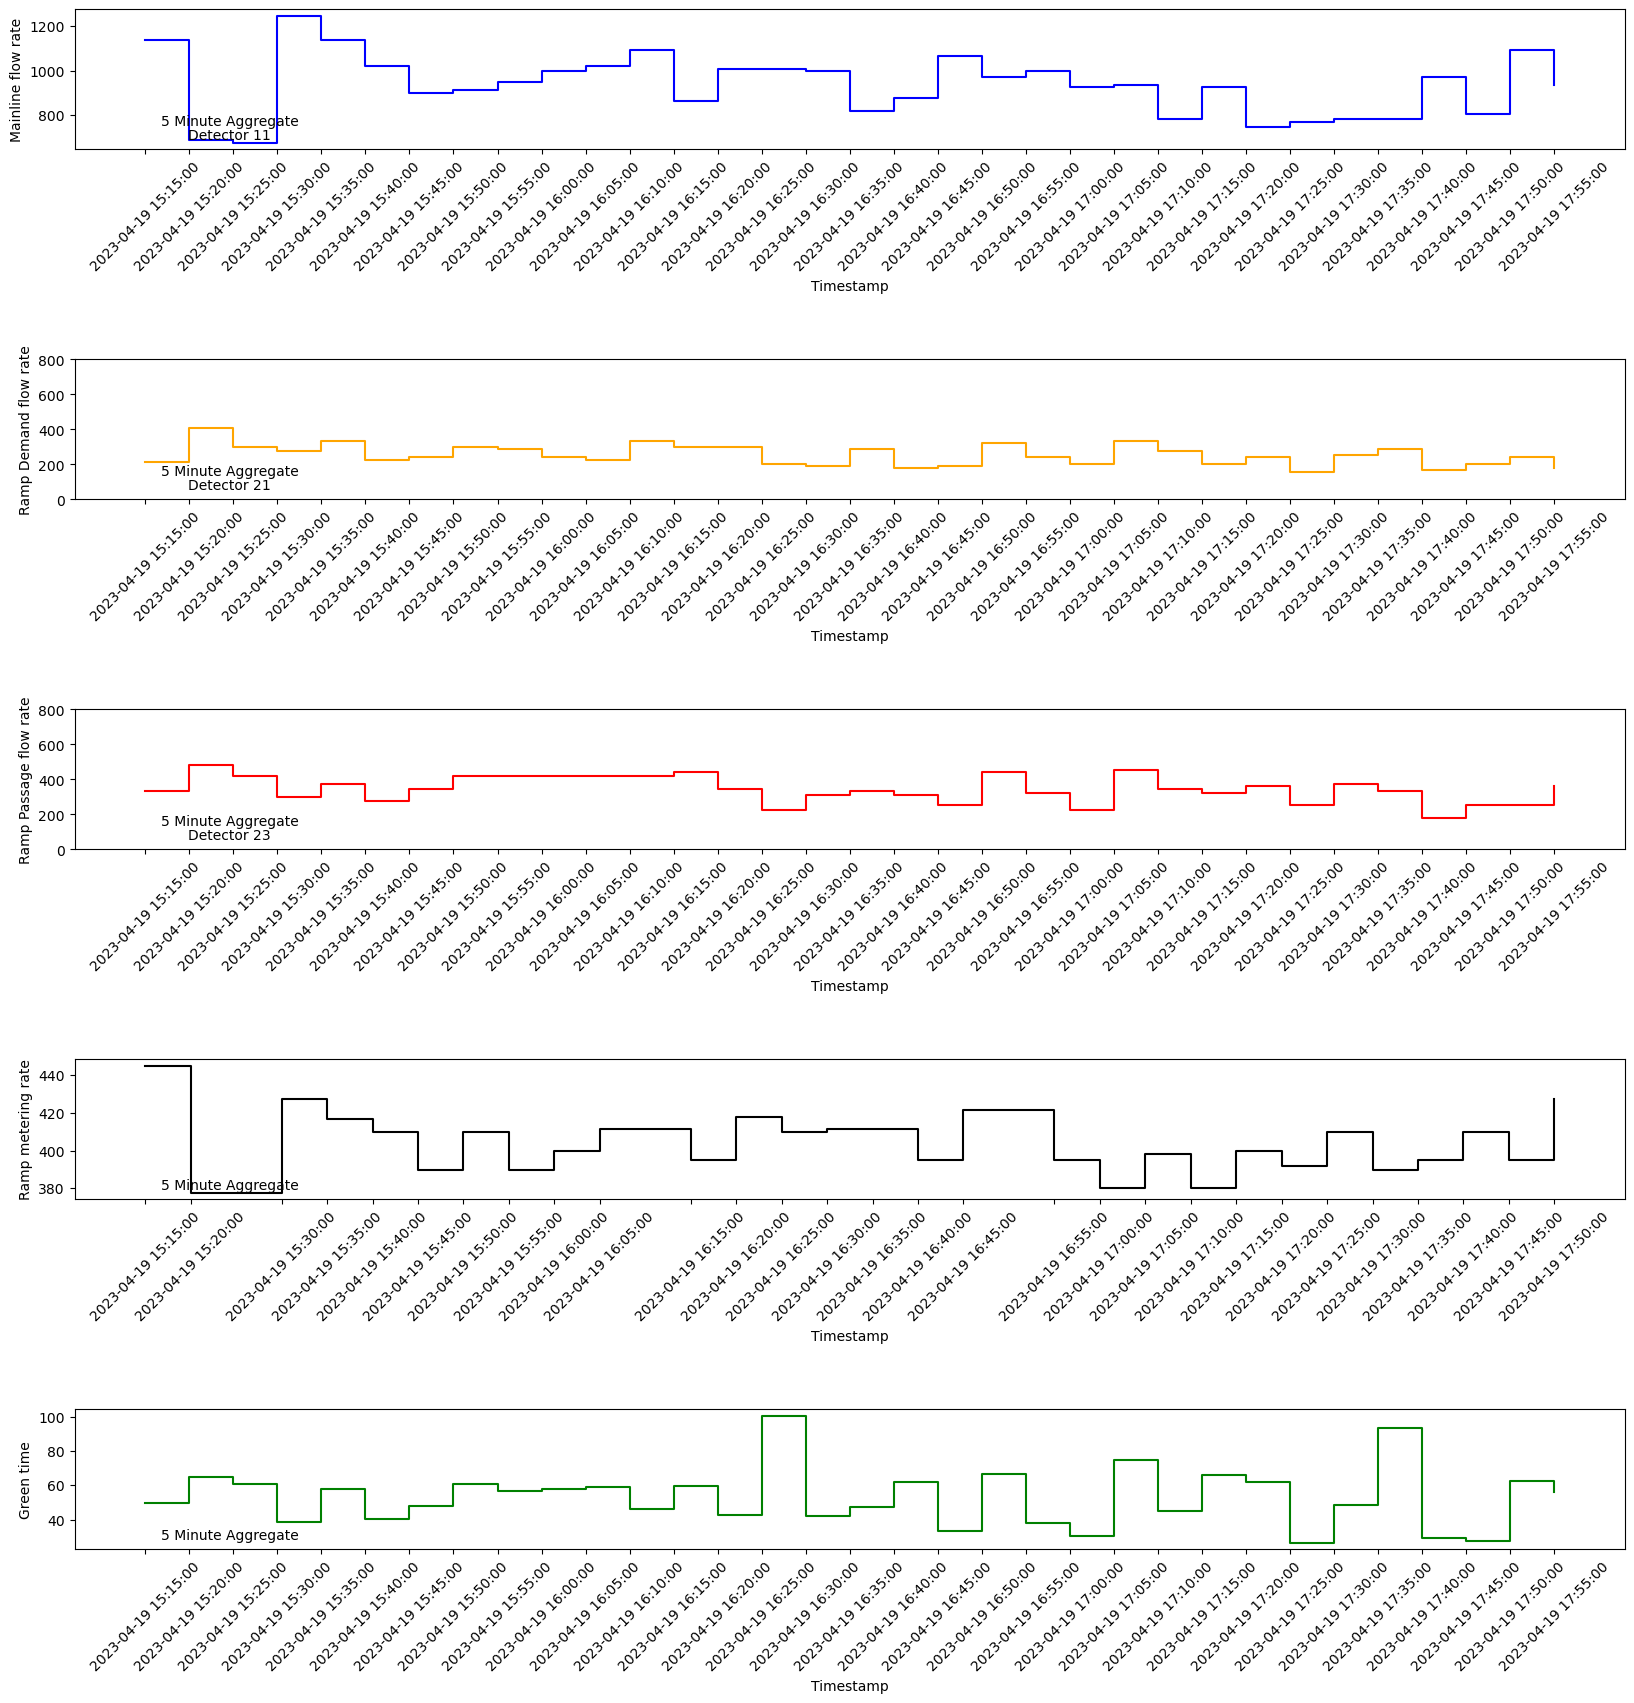

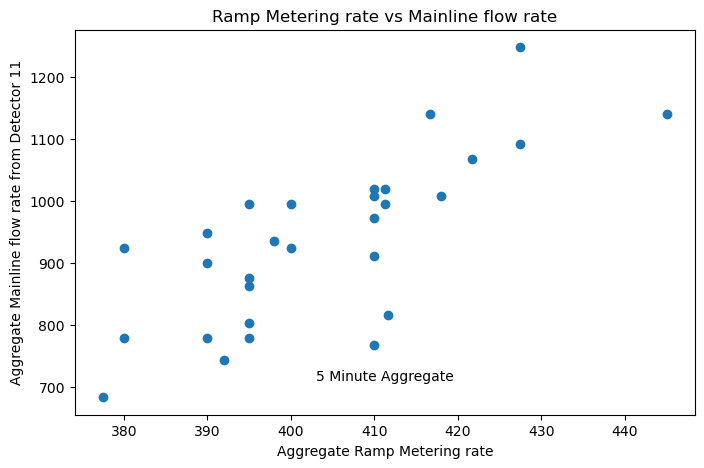

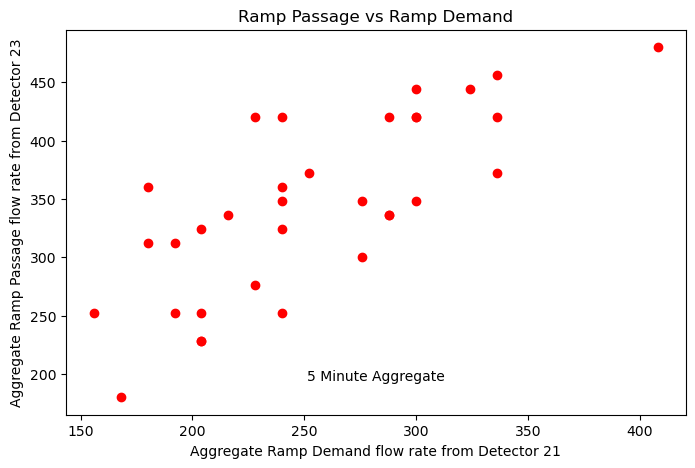

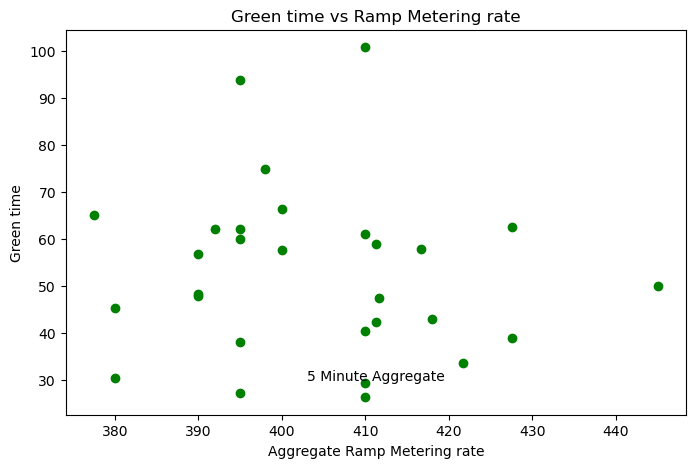

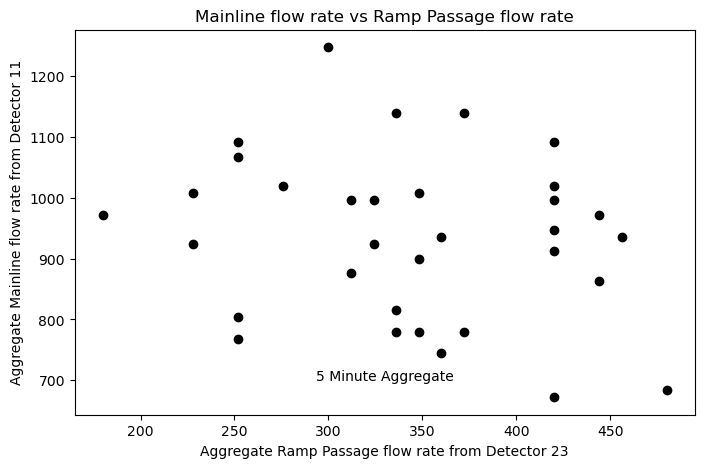

In [119]:
plot_function(df_event_detail,5)

   measurement_start_timestamp  Average Speed  Average Flow  \
0          2023-04-19 15:15:00      27.133333            96   
1          2023-04-19 15:20:00      13.800000            62   
2          2023-04-19 15:25:00      12.600000            56   
3          2023-04-19 15:30:00      23.466667           105   
4          2023-04-19 15:35:00      20.800000            93   
5          2023-04-19 15:40:00      20.866667            87   
6          2023-04-19 15:45:00      17.200000            79   
7          2023-04-19 15:50:00      15.400000            74   
8          2023-04-19 15:55:00      16.400000            84   
9          2023-04-19 16:00:00      18.333333            83   
10         2023-04-19 16:05:00      17.800000            86   
11         2023-04-19 16:10:00      20.533333            90   
12         2023-04-19 16:15:00      18.266667            72   
13         2023-04-19 16:20:00      18.866667            93   
14         2023-04-19 16:25:00      19.266667          

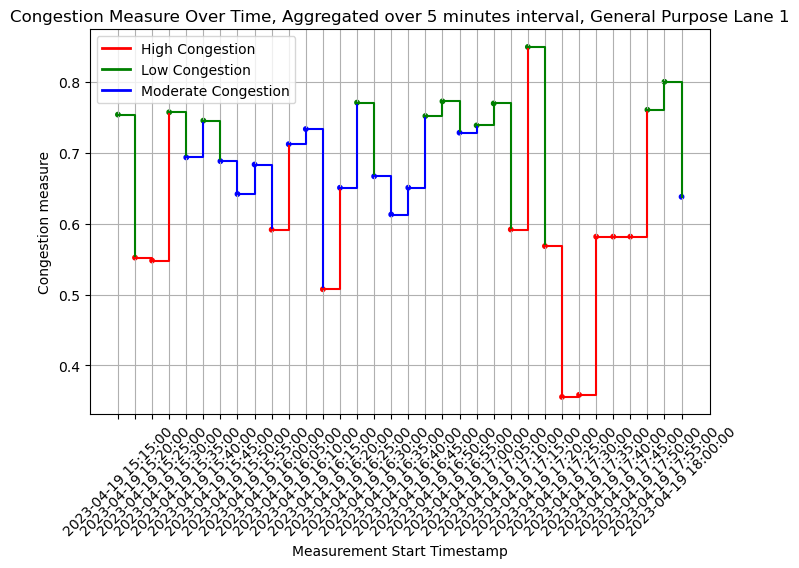

[0.61049359 0.73389744]


In [175]:
plot_congestion(df,5,1)

In [176]:
df_aggregate

,measurement_start_timestamp,Average Speed,Average Flow,Average Occupancy,Max Speed,Average Flow Rate,Congestion measure
0,2023-04-19 00:00:00,66.357143,31,3.000000,81.0,372.0,0.819224
1,2023-04-19 00:05:00,66.714286,35,2.642857,74.0,420.0,0.901544
2,2023-04-19 00:10:00,61.142857,35,3.285714,74.0,420.0,0.826255
3,2023-04-19 00:15:00,69.000000,29,2.642857,89.0,348.0,0.775281
4,2023-04-19 00:20:00,65.153846,22,2.000000,81.0,264.0,0.804368
...,...,...,...,...,...,...,...
283,2023-04-19 23:35:00,68.500000,31,2.785714,87.0,372.0,0.787356
284,2023-04-19 23:40:00,68.214286,35,2.642857,79.0,420.0,0.863472
285,2023-04-19 23:45:00,67.923077,32,2.769231,76.0,384.0,0.893725
286,2023-04-19 23:50:00,71.466667,35,2.400000,86.0,420.0,0.831008


In [178]:
list(df_aggregate.columns)

['measurement_start_timestamp',
 'Average Speed',
 'Average Flow',
 'Average Occupancy',
 'Max Speed',
 'Average Flow Rate',
 'Congestion measure']

In [179]:
df

,zone_id,lane_number,lane_id,measurement_start,speed,volume,occupancy,quality,measurement_start_timestamp
0,15446,1,45827,2023-04-19T00:00:01-04:00,64.0,2,6,0,2023-04-19 00:00:01
1,15446,1,45827,2023-04-19T00:00:21-04:00,62.0,1,1,0,2023-04-19 00:00:21
3,15446,1,45827,2023-04-19T00:01:01-04:00,65.0,1,4,0,2023-04-19 00:01:01
4,15446,1,45827,2023-04-19T00:01:21-04:00,65.0,1,1,0,2023-04-19 00:01:21
5,15446,1,45827,2023-04-19T00:01:41-04:00,56.0,3,4,0,2023-04-19 00:01:41
...,...,...,...,...,...,...,...,...,...
4310,15446,1,45827,2023-04-19T23:57:33-04:00,73.0,1,1,0,2023-04-19 23:57:33
4311,15446,1,45827,2023-04-19T23:57:53-04:00,70.0,4,4,0,2023-04-19 23:57:53
4312,15446,1,45827,2023-04-19T23:58:13-04:00,65.0,1,1,0,2023-04-19 23:58:13
4313,15446,1,45827,2023-04-19T23:58:33-04:00,71.0,3,3,0,2023-04-19 23:58:33


In [182]:
cd ./MVDS\ raw\ data

/Users/sainikhil/Downloads/RADISH/2023-04-19 Cypress 101 data/MVDS raw data


In [185]:
df = pd.read_csv('Lane_Readings_15425-1-45777.csv')
df['measurement_start_timestamp'] = df['measurement_start'].apply(lambda x:str(x.split('T')[0]) + str(' ')+str(x.split('T')[1].split('-')[0]))
df = df.dropna(subset=['speed', 'volume', 'occupancy'])
df = df[(df['speed']>=0) & (df['volume']>=0) & (df['occupancy']>=0)]
df['measurement_start_timestamp'] = pd.to_datetime(df['measurement_start_timestamp'])
df_average_speed = pd.DataFrame({'Average Speed':df.groupby(pd.Grouper(key='measurement_start_timestamp',freq='{}min'.format(5))).speed.mean()}).reset_index()
df_average_speed

,measurement_start_timestamp,Average Speed
0,2023-04-19 00:00:00,85.000000
1,2023-04-19 00:05:00,88.250000
2,2023-04-19 00:10:00,87.333333
3,2023-04-19 00:15:00,85.000000
4,2023-04-19 00:20:00,81.666667
...,...,...
283,2023-04-19 23:35:00,90.800000
284,2023-04-19 23:40:00,85.000000
285,2023-04-19 23:45:00,93.833333
286,2023-04-19 23:50:00,89.000000


In [184]:
df

,zone_id,lane_number,lane_id,measurement_start,speed,volume,occupancy,quality
0,15425,1,45777,2023-04-19T00:00:01-04:00,NaN,0,0,1
1,15425,1,45777,2023-04-19T00:00:21-04:00,NaN,0,0,1
2,15425,1,45777,2023-04-19T00:00:41-04:00,86.0,2,1,1
3,15425,1,45777,2023-04-19T00:01:01-04:00,NaN,0,0,1
4,15425,1,45777,2023-04-19T00:01:21-04:00,NaN,0,0,1
...,...,...,...,...,...,...,...,...
4308,15425,1,45777,2023-04-19T23:57:33-04:00,72.0,1,1,0
4309,15425,1,45777,2023-04-19T23:57:53-04:00,NaN,0,1,1
4310,15425,1,45777,2023-04-19T23:58:13-04:00,NaN,0,0,1
4311,15425,1,45777,2023-04-19T23:58:33-04:00,NaN,0,0,1
